## 1. GEM environment Libraries
(Finite Control Set Current Control Permanent Magnet Synchronous Motor Environment)

In [ ]:
%matplotlib notebook
# Use %matplotlib widget in Visual Studio Code
import numpy as np
from pathlib import Path
import gym_electric_motor as gem
from gym_electric_motor.reference_generators import \
    MultipleReferenceGenerator,\
    WienerProcessReferenceGenerator
from gym_electric_motor.visualization import MotorDashboard
from gym.spaces import Discrete, Box
from gym.wrappers import FlattenObservation, TimeLimit
from gym import ObservationWrapper

## 2. GEM enviroment set up

### 2.1 Physical System

Each system consists of a voltage supply, a power electronic converter, an electrical motor, and the mechanical load (SCML) as shown in the above figure. Each such SCML-system is simulated by a user-defined ODE solver.

### 2.1.1 Voltage Supply

The voltage supply module provides both, DC and AC voltage supplies.

The DC supplies are either ideal or non-ideal voltage sources.
The AC supplies are either ideal single phase or ideal three-phase AC sources

### 2.1.2 Converter

# PMSM
The basic idea of the control setup from the GEM-environment is displayed in the following figure.

The agent controls the converter who converts the supply currents to the currents flowing into the motor - for the PSMS:  𝑖𝑠𝑞  and  𝑖𝑠𝑑 
In the continuous case, the agent's action equals a duty cycle which will be modulated into a corresponding voltage.

In the discrete case, the agent's actions denote switching states of the converter at the given instant. Here, only a discrete amount of options are available. In this notebook, for the PMSM the discrete B6 bridge converter with six switches is utilized per default. This converter provides a total of eight possible actions.

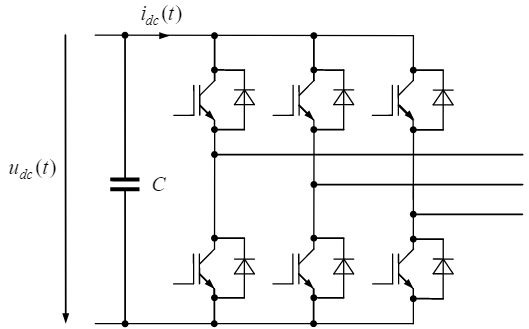

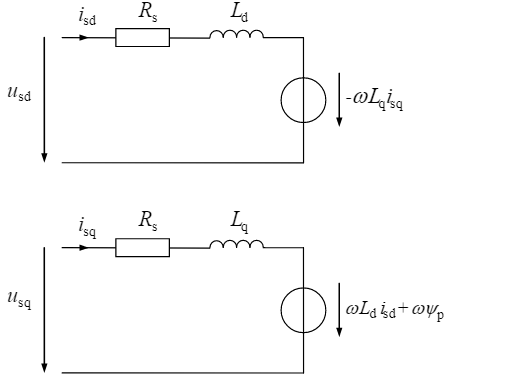

And the electrical ODEs for that motor are:

<h3 align="center">

<!-- $\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$
 -->

   $ \frac{\mathrm{d}i_{sd}}{\mathrm{d}t}=\frac{u_{sd} + p\omega_{me}L_q i_{sq} - R_s i_{sd}}{L_d} $ <br><br>
    $\frac{\mathrm{d} i_{sq}}{\mathrm{d} t}=\frac{u_{sq} - p \omega_{me} (L_d i_{sd} + \mathit{\Psi}_p) - R_s i_{sq}}{L_q}$ <br><br>
   $\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>
The target for the agent is now to learn to control the currents. For this, a reference generator produces a trajectory that the agent has to follow. Therefore, it has to learn a function (policy) from given states, references and rewards to appropriate actions

### 2.1.3  Motor State Initializer

 Mechanical Load - The mechanical load module in GEM models various external mechanical systems that apply counterforces on the electrical motor's rotor through the drive shaft.The load type: ConstSpeedLoad is used. This initializes the load with a constant speed at the start of each episode. The initialization value for speed is sampled from a uniform distribution defined by the given interval.

### 2.1.4 Reward Function

The reward calculation is based on the current state and reference of the motor environment. It is calculated as a weighted sum of errors with a certain power as follows:

<!-- <h3 align="center"> -->
<!-- $ reward = - reward\_weights * (abs(state - reference)/ state\_length)^{reward\_power}$   -->

$ r_t = - \sum \limits_{k=0} ^{N} w_{\{k\}}\big | s_{\{k\}t} - s^*_{\{k\}t} \big |^p $   <br> <br>


Here,  𝑟𝑡  is the reward at time  𝑡 .  𝑤{𝑘}  is the reward weight for the k'th state variable of the  𝑁  referenced states .  𝑠{𝑘}𝑡  is the k'th state variable of the motor and  𝑠∗{𝑘}𝑡  is the corresponding k'th reference variable at time  𝑡 . The reward power is  𝑝 .

A constraint violation is also introduced 

### 2.1.5 Constraint Monitor

The constraint monitor monitors the system states and assesses whether they violate system boundaries specified by the constraints.

The constraints can be selected from a predefined set within GEM or defined by the user.



# 3. Visualization 

The visualization module provides an interface to observe and inspect the physical system's states, references, rewards, etc. GEM offers two forms of visualization:

Motor dashboard: A graphical interface which provides visualization in the form of plots.

Console printer: A simpler interface in the form of console print-outs.

## 3.1 Physical System Wrappers
Physical System Wrappers wrap the physical system to preprocess the actions and postprocess the states of the Physical Systems.

In [2]:
class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation. Serves
    the purpose to improve the agent's learning speed.
    
    It changes epsilon to cos(epsilon) and sin(epsilon). This serves the purpose
    to have the angles -pi and pi close to each other numerically without losing
    any information on the angle.
    
    Additionally, this wrapper adds a new observation i_sd**2 + i_sq**2. This should
    help the agent to easier detect incoming limit violations.
    """

    def __init__(self, env, epsilon_idx, i_sd_idx, i_sq_idx):
        """
        Changes the observation space to fit the new features
        
        Args:
            env(GEM env): GEM environment to wrap
            epsilon_idx(integer): Epsilon's index in the observation array
            i_sd_idx(integer): I_sd's index in the observation array
            i_sq_idx(integer): I_sq's index in the observation array
        """
        super(FeatureWrapper, self).__init__(env)
        self.EPSILON_IDX = epsilon_idx
        self.I_SQ_IDX = i_sq_idx
        self.I_SD_IDX = i_sd_idx
        new_low = np.concatenate((self.env.observation_space.low[
                                  :self.EPSILON_IDX], np.array([-1.]),
                                  self.env.observation_space.low[
                                  self.EPSILON_IDX:], np.array([0.])))
        new_high = np.concatenate((self.env.observation_space.high[
                                   :self.EPSILON_IDX], np.array([1.]),
                                   self.env.observation_space.high[
                                   self.EPSILON_IDX:],np.array([1.])))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation. Adds the new features to the
        observation and removes original epsilon.
        
        """
        cos_eps = np.cos(observation[self.EPSILON_IDX] * np.pi)
        sin_eps = np.sin(observation[self.EPSILON_IDX] * np.pi)
        currents_squared = observation[self.I_SQ_IDX]**2 + observation[self.I_SD_IDX]**2
        observation = np.concatenate((observation[:self.EPSILON_IDX],
                                      np.array([cos_eps, sin_eps]),
                                      observation[self.EPSILON_IDX + 1:],
                                      np.array([currents_squared])))
        return observation

## 3.2 GEM call
#### converter and motor specification


In [3]:
# define motor arguments
motor_parameter = dict(
    p=3,  # [p] = 1, nb of pole pairs
    r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
    l_d=0.37e-3,  # [l_d] = H, d-axis inductance
    l_q=1.2e-3,  # [l_q] = H, q-axis inductance
    psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
)
# supply voltage
u_supply = 350

# nominal and absolute state limitations
nominal_values=dict(
    omega=4000*2*np.pi/60,
    i=230,
    u=u_supply
)
limit_values=dict(
    omega=4000*2*np.pi/60,
    i=1.5*230,
    u=u_supply
)

# sampling interval
tau = 1e-5

# define maximal episode steps
max_eps_steps = 10000


motor_initializer={'random_init': 'uniform', 'interval': [[-230, 230], [-230, 230], [-np.pi, np.pi]]}
reward_function=gem.reward_functions.WeightedSumOfErrors(
    reward_weights={'i_sq': 10, 'i_sd': 10},
    gamma=0.99,  # discount rate 
    reward_power=1
)
motor_dashboard = MotorDashboard(state_plots=['i_sq', 'i_sd'], reward_plot=True)

# creating gem environment
env = gem.make(  # define a PMSM with discrete action space
    "Finite-CC-PMSM-v0",
    # visualize the results
    visualization=motor_dashboard,
    
    # parameterize the PMSM and update limitations
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=motor_initializer,
    ),
    # define the random initialisation for load and motor
    load=dict(
        load_initializer={'random_init': 'uniform', },
    ),
    reward_function=reward_function,
    supply=dict(u_nominal=u_supply),
    # define the duration of one sampling step
    tau=tau,
    
    ode_solver='euler',
)

# remove one action from the action space to help the agent speed up its training
# this can be done as both switchting states (1,1,1) and (-1,-1,-1) - which are encoded
# by action 0 and 7 - both lead to the same zero voltage vector in alpha/beta-coordinates
env.action_space = Discrete(7)

# applying wrappers
eps_idx = env.physical_system.state_names.index('epsilon')
i_sd_idx = env.physical_system.state_names.index('i_sd')
i_sq_idx = env.physical_system.state_names.index('i_sq')
env = TimeLimit(
    FeatureWrapper(
        FlattenObservation(env), 
        eps_idx, i_sd_idx, i_sq_idx
    ),
    max_eps_steps
)

C:\Users\Habsman\anaconda3\envs\testNN\lib\site-packages\gym\spaces\box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## 3.3 Training: 

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

C:\Users\Habsman\anaconda3\envs\testNN\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\Habsman\anaconda3\envs\testNN\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\Habsman\anaconda3\envs\testNN\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query

## 3.3.1 Model design 
Using a time series prediction model, and relu activation function, three layers are generated, input, hidden, and output layer.

In [5]:
# Training parameters.
time_limit = True
buffer_size = 200000  # observation history size
batch_size = 25  # mini batch size sampled from history at each update step
nb_actions = env.action_space.n
window_length = 1

# construct a MLP
model = Sequential()
model.add(Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(Dense(64, activation='relu'))  # hidden layer 1
model.add(Dense(64, activation='relu'))  # hidden layer 2
model.add(Dense(nb_actions, activation='linear'))  # output layer

# keras-rl2 objects
memory = SequentialMemory(limit=200000, window_length=window_length)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(eps=0.2), 'eps', 1, 0.05, 0, 50000)

## 3.3.2 Train an Agent with Keras-RL2

In [6]:
dqn = DQNAgent(
    model=model,
    policy=policy,
    nb_actions=nb_actions,
    memory=memory,
    gamma=0.99,
    batch_size=25,
    train_interval=1,
    memory_interval=1,
    target_model_update=1000,
    nb_steps_warmup=10000,
    enable_double_dqn=True
)

dqn.compile(
    Adam(lr=1e-4),
    metrics=['mse']
)

C:\Users\Habsman\anaconda3\envs\testNN\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


<IPython.core.display.Javascript object>


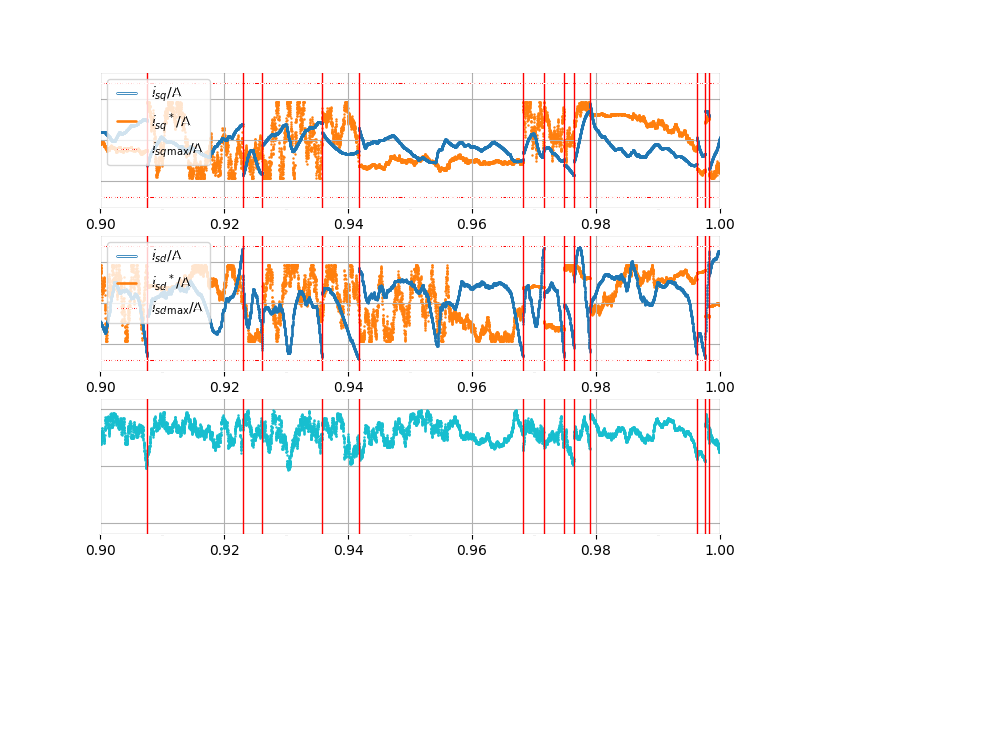

In [7]:
motor_dashboard.initialize()

In [8]:

history = dqn.fit(
    env,
    nb_steps=100000,
    action_repetition=1,
    verbose=2,
    visualize=True,
    nb_max_episode_steps=10000,
    log_interval=1000
)

Training for 100000 steps ...


C:\Users\Habsman\anaconda3\envs\testNN\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    93/100000: episode: 1, duration: 4.048s, episode steps:  93, steps per second:  23, episode reward: -2386.334, mean reward: -25.660 [-2000.000, -1.163], mean action: 3.065 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
   143/100000: episode: 2, duration: 0.241s, episode steps:  50, steps per second: 208, episode reward: -2313.897, mean reward: -46.278 [-2000.000, -5.072], mean action: 2.640 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
   191/100000: episode: 3, duration: 0.245s, episode steps:  48, steps per second: 196, episode reward: -2336.027, mean reward: -48.667 [-2000.000, -5.557], mean action: 3.479 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
  1863/100000: episode: 4, duration: 9.923s, episode steps: 1672, steps per second: 168, episode reward: -9404.996, mean reward: -5.625 [-2000.000, -0.431], mean action: 3.020 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
  2173/100000: episode: 5, duration: 1.907s, episode

C:\Users\Habsman\anaconda3\envs\testNN\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 11963/100000: episode: 35, duration: 68.286s, episode steps: 2926, steps per second:  43, episode reward: -12707.736, mean reward: -4.343 [-2000.000, -0.103], mean action: 2.959 [0.000, 6.000],  loss: 6687.164693, mse: 1912.366890, mean_q: -0.568255, mean_eps: 0.791352
 12064/100000: episode: 36, duration: 3.621s, episode steps: 101, steps per second:  28, episode reward: -2646.967, mean reward: -26.208 [-2000.000, -3.955], mean action: 3.178 [0.000, 6.000],  loss: 9480.360142, mse: 2715.878532, mean_q: -1.936478, mean_eps: 0.771753
 13326/100000: episode: 37, duration: 41.288s, episode steps: 1262, steps per second:  31, episode reward: -9222.212, mean reward: -7.308 [-2000.000, -3.046], mean action: 3.176 [0.000, 6.000],  loss: 6808.913107, mse: 1968.509004, mean_q: -3.837777, mean_eps: 0.758804
 13396/100000: episode: 38, duration: 2.267s, episode steps:  70, steps per second:  31, episode reward: -2563.003, mean reward: -36.614 [-2000.000, -7.627], mean action: 3.071 [0.000, 6.000

### saving the model

In [9]:
weight_path = Path('C:\\Users\\Habsman\\Desktop\\codes\\recursive\\saved_models_gem')
weight_path.mkdir(parents=True, exist_ok=True)
dqn.save_weights(str(weight_path / 'dqn_keras-RL2.hdf5'), overwrite=True) 

### loading model 

In [10]:
try:
    dqn.load_weights(str(weight_path / 'dqn_keras-RL2.hdf5'))
except OSError:
    print('Could not find model file. Continue')   

## 3.3.3 Testing Model

<IPython.core.display.Javascript object>


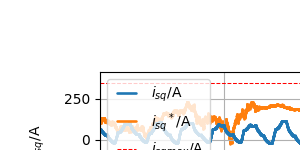

In [11]:
motor_dashboard.initialize()

In [12]:
env.reset()
test_history = dqn.test(env,
                         nb_episodes=5,
                         nb_max_episode_steps=100000,
                         visualize=True
                         )

Testing for 5 episodes ...
Episode 1: reward: -3911.215, steps: 415
Episode 2: reward: -5159.525, steps: 533
Episode 3: reward: -30578.592, steps: 10000
Episode 4: reward: -13157.923, steps: 2971
Episode 5: reward: -2588.916, steps: 210
